In [93]:
import os
import numpy as np
import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
from ast import literal_eval
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.backend as K
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle
import tensorflow as tf

In [ ]:
!gdown https://drive.google.com/uc?id=1wcHFahPpjG6sFNKVY30Hch8TwQI-5gLj

In [3]:
!gdown https://drive.google.com/uc?id=1BX0WSniYjkU4LuOuLnfcNAvK7Pd5sc_l


Downloading...
From: https://drive.google.com/uc?id=1BX0WSniYjkU4LuOuLnfcNAvK7Pd5sc_l
To: /content/train-512-png.zip
100% 791M/791M [00:04<00:00, 168MB/s]


In [4]:
!unzip train-512-png.zip

Streaming output truncated to the last 5000 lines.
  inflating: train-512-png/decb2d392c57.png  
  inflating: train-512-png/8d7102bde380.png  
  inflating: train-512-png/8ddd063f5c7d.png  
  inflating: train-512-png/5b6f5159204f.png  
  inflating: train-512-png/03cafeb389a1.png  
  inflating: train-512-png/5d395fff6278.png  
  inflating: train-512-png/cd854980742c.png  
  inflating: train-512-png/967482047b0c.png  
  inflating: train-512-png/1843ab225632.png  
  inflating: train-512-png/576bb6054ad3.png  
  inflating: train-512-png/55839276a9c9.png  
  inflating: train-512-png/12fd7e210fae.png  
  inflating: train-512-png/fbd384384f57.png  
  inflating: train-512-png/0c5302698d64.png  
  inflating: train-512-png/458d3c84b5d4.png  
  inflating: train-512-png/136af218f8df.png  
  inflating: train-512-png/58d616c1a4d4.png  
  inflating: train-512-png/d60594828264.png  
  inflating: train-512-png/df0fe96fc60a.png  
  inflating: train-512-png/bb484ab7a8c6.png  
  inflating: train-512-png/e9

In [138]:
df_metadata = pd.read_csv('size.csv')

In [140]:
df_image = pd.read_csv('train_image_level.csv')
df_study = pd.read_csv('train_study_level.csv')

# merge two dataset for ease manipulation
df_study['id'] = df_study['id'].str.replace('_study', '')
df_study.rename({'id' : 'StudyInstanceUID'}, axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')

# create new col for label class
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)


df_train['id'] = df_train['id'].str.replace('_image', '.png')

# split label for just getting opacity/none label
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])
df_train = df_train.merge(df_metadata, on='id')

df_train.head(3)

id  ...  split
0  000a312787f2.png  ...  train
1  000c3a3f293f.png  ...  train
2  0012ff7358bc.png  ...  train

[3 rows x 9 columns]

In [ ]:
all_files = []
for dirname, _, filenames in os.walk('train'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

In [6]:
def preprocess_image(img):
    # python -m pip install -U scikit-image
    equ_img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24)
    return equ_img


(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


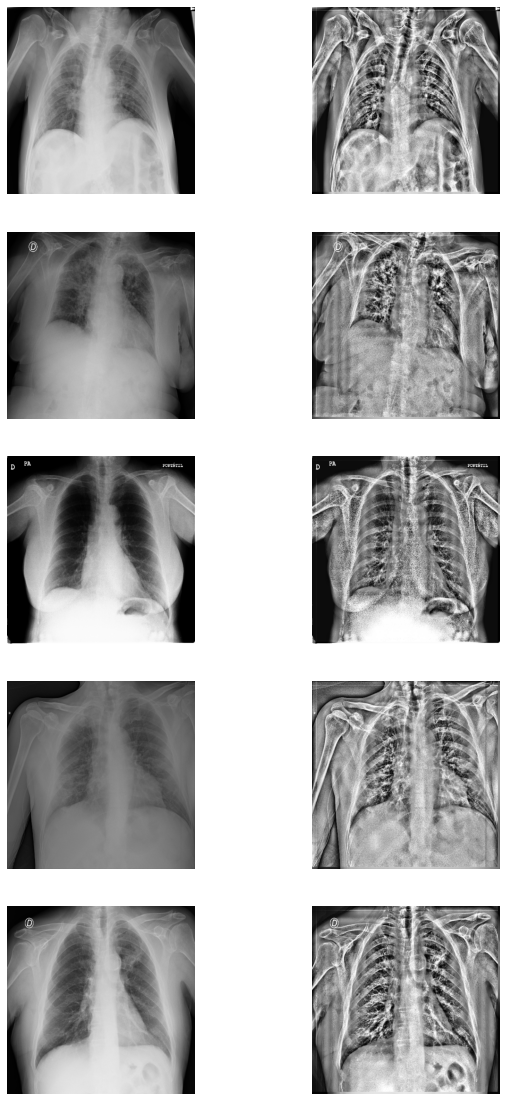

In [148]:

df_opa = df_train[df_train['image_label'] == 'opacity'].reset_index()
fig, axs = plt.subplots(5, 2, figsize=(10,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
n = 5
for i in range(n):
    img = cv2.imread(os.path.join(train_dir, df_opa['id'][i]))
    print(img.shape)
    img_proc = preprocess_image(img)
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img_proc)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

In [7]:
img_size = 224
batch_size = 16

image_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=preprocess_image
    
)

image_generator_valid = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_image)

train_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    seed=23
)

valid_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=23
)

Found 4864 validated image filenames belonging to 2 classes.
Found 1215 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 255 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 255 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


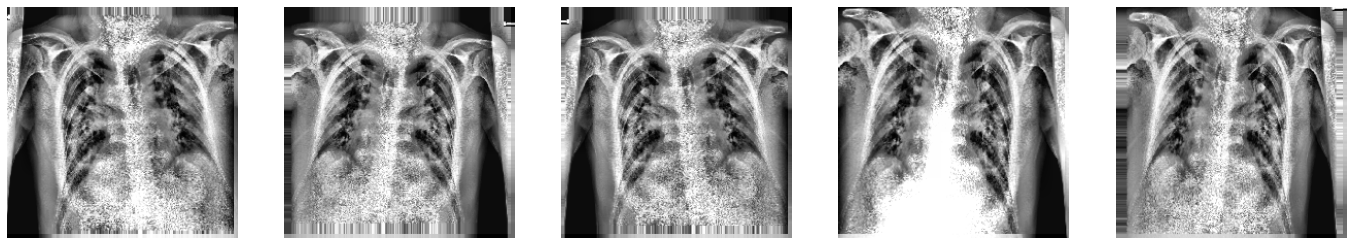

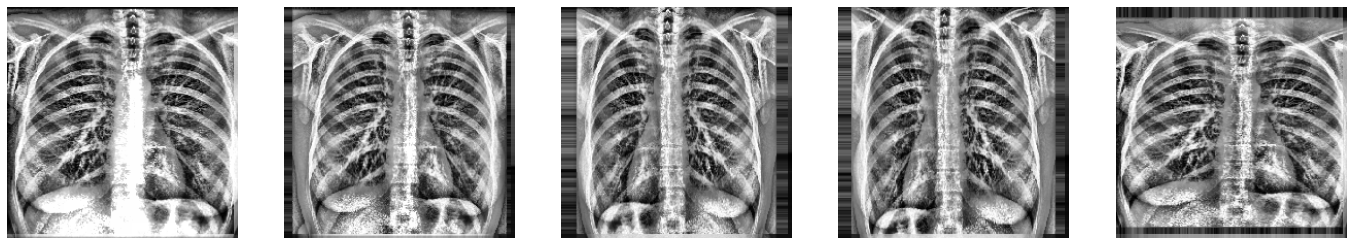

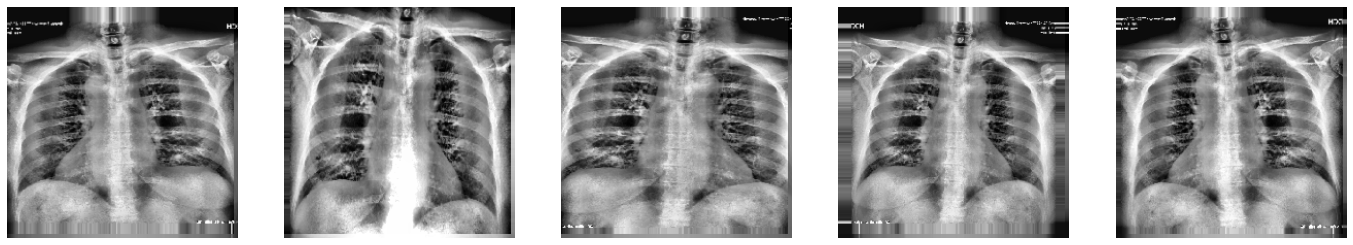

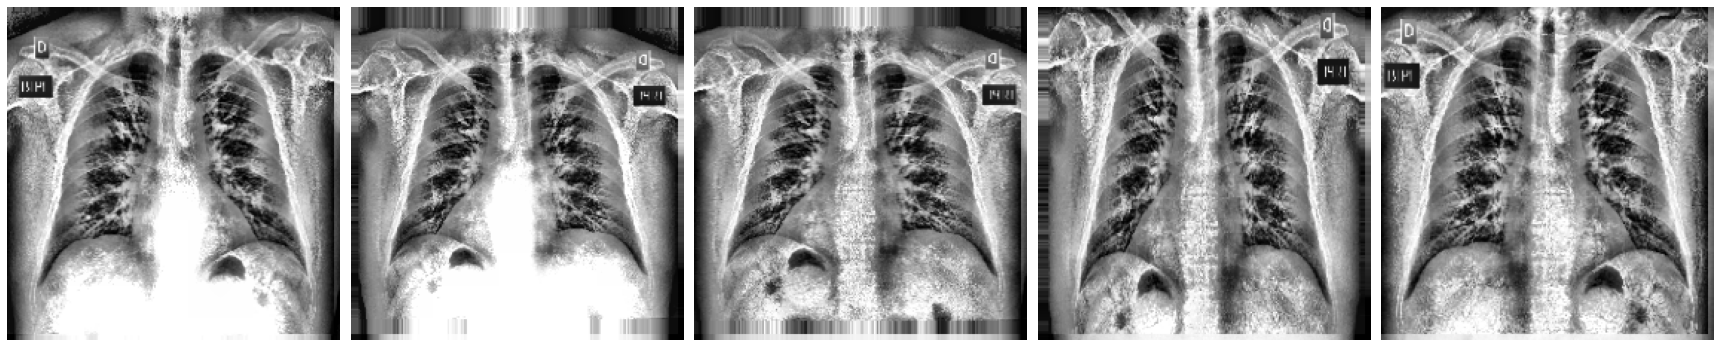

In [8]:
for j in range(4):
    aug_images = [train_generator[0][0][j] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize=(24,24))
    axes = axes.flatten()
    for img, ax in zip(aug_images, axes):
        ax.imshow(img)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

In [89]:
#def load_process(img, img_size):
#    img=load_img(img, target_size=(img_size, img_size))
#    img=preprocess_image(img)
#    img=img_to_array(img)
#    img=img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
#    return img

def load_process(img, img_size):
    img = load_img(img, target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_image(img)
    return img


In [10]:
chex_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

pre_model = DenseNet121(weights=None, include_top=False, input_shape=(img_size, img_size,3))

out = Dense(14, activation='sigmoid')(pre_model.output)

pre_model = Model(inputs=pre_model.input, outputs=out)

pre_model.load_weights(chex_weights_path)

pre_model.trainable = False

x =  pre_model.layers[-2].output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)

model = Model(pre_model.input, output)

In [11]:
model.compile(Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics='accuracy')

In [12]:
rlr = ReduceLROnPlateau(monitor='val_accuracy', 
                        factor=0.2, 
                        patience=2, 
                        verbose=1, 
                        min_delta= 1e-4, 
                        min_lr = 1e-4,
                       mode='max')
es = EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-4,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1)

ckp = ModelCheckpoint('model.h5', 
                      monitor='val_accuracy',
                     verbose=0,
                     save_best_only=True,
                     mode='max')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[es, rlr, ckp],
    verbose=1
)

Epoch 1/20
304/304 [==============================] - 419s 1s/step - loss: 0.6012 - accuracy: 0.6875 - val_loss: 0.6383 - val_accuracy: 0.6412
Epoch 2/20
304/304 [==============================] - 381s 1s/step - loss: 0.5682 - accuracy: 0.7167 - val_loss: 0.6130 - val_accuracy: 0.6551
Epoch 3/20
304/304 [==============================] - 381s 1s/step - loss: 0.5494 - accuracy: 0.7282 - val_loss: 0.5863 - val_accuracy: 0.6831
Epoch 4/20
304/304 [==============================] - 378s 1s/step - loss: 0.5364 - accuracy: 0.7444 - val_loss: 0.6040 - val_accuracy: 0.6774
Epoch 5/20
304/304 [==============================] - 376s 1s/step - loss: 0.5295 - accuracy: 0.7414 - val_loss: 0.5902 - val_accuracy: 0.6947
Epoch 6/20
304/304 [==============================] - 377s 1s/step - loss: 0.5310 - accuracy: 0.7447 - val_loss: 0.5989 - val_accuracy: 0.6774
Epoch 7/20
304/304 [==============================] - 380s 1s/step - loss: 0.5256 - accuracy: 0.7498 - val_loss: 0.5717 - val_accuracy: 0.7037

Fine-tuning

In [ ]:
pre_model.trainable = True
model.compile(Adam(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics='accuracy')

In [ ]:

rlr2 = ReduceLROnPlateau(monitor='val_accuracy', 
                        factor=0.1,
                       patience=2,
                       verbose=1,
                       min_delta=1e-4,
                       min_lr=1e-7,
                       mode='max')

es2 = EarlyStopping(monitor='val_accuracy', 
                    min_delta=1e-4,
                   patience=7,
                   mode='max',
                   restore_best_weights=True,
                   verbose=1)

history2 = model.fit(train_generator,
                    epochs=40,
                    validation_data=valid_generator,
                    callbacks=[es2, rlr2, ckp],
                    verbose=1)

K.clear_session()

Epoch 1/40
304/304 [==============================] - 2351s 8s/step - loss: 0.8144 - accuracy: 0.6264 - val_loss: 0.6332 - val_accuracy: 0.7218
Epoch 2/40
304/304 [==============================] - 3019s 10s/step - loss: 0.6167 - accuracy: 0.7229 - val_loss: 0.5997 - val_accuracy: 0.7383
Epoch 3/40
304/304 [==============================] - 2324s 8s/step - loss: 0.5593 - accuracy: 0.7556 - val_loss: 0.6106 - val_accuracy: 0.7243
Epoch 4/40
304/304 [==============================] - 2309s 8s/step - loss: 0.5366 - accuracy: 0.7693 - val_loss: 0.5810 - val_accuracy: 0.7416
Epoch 5/40
304/304 [==============================] - 2517s 8s/step - loss: 0.5258 - accuracy: 0.7710 - val_loss: 0.5965 - val_accuracy: 0.7333
Epoch 6/40
304/304 [==============================] - 2943s 10s/step - loss: 0.5307 - accuracy: 0.7630 - val_loss: 0.5837 - val_accuracy: 0.7374

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 7/40
304/304 [==============================] -

In [19]:
model.save_weights('checkpoint_1')

In [20]:
loss_values = pd.DataFrame(model.history.history)

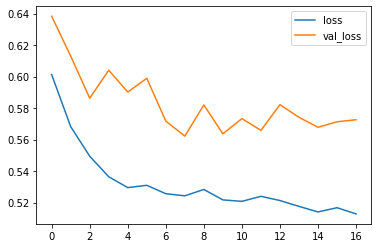

In [21]:
loss_values[['loss', 'val_loss']].plot()

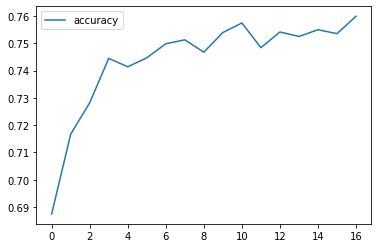

In [22]:
loss_values[['accuracy']].plot()

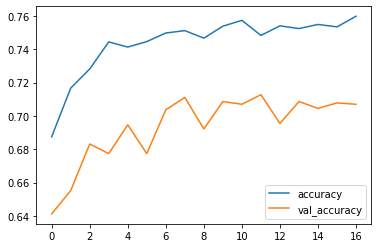

In [29]:
loss_values[['accuracy', 'val_accuracy']].plot()

Measuring Performance

In [25]:
actual =  valid_generator.labels
preds = np.argmax(model.predict(valid_generator), axis=1)
cfmx = confusion_matrix(actual, preds)
acc = accuracy_score(actual, preds)

Test Accuracy: 0.697119341563786


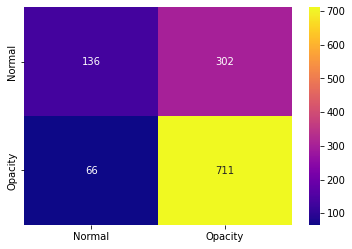

In [26]:
print ('Test Accuracy:', acc )
heatmap(cfmx, annot=True, cmap='plasma',
        xticklabels=['Normal','Opacity'],fmt='.0f', yticklabels=['Normal', 'Opacity'])
plt.show()

In [35]:
train_dir = 'train-512-png'

def grad_cam(input_image, model, layer_name):

    desired_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [desired_layer.output, model.output])

    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(input_image)
        ix = (np.argsort(preds, axis=1)[:, -1]).item()
        output_idx = preds[:, ix]

    gradient = tape.gradient(output_idx, layer_output)
    alpha_kc = np.mean(gradient, axis=(0,1,2))
    L_gradCam = tf.nn.relu(np.dot(layer_output, alpha_kc)[0])
    L_gradCam = (L_gradCam - np.min(L_gradCam)) / (np.max(L_gradCam) - np.min(L_gradCam)) 
    return L_gradCam.numpy()



In [31]:
def blend(img_path, gradCam_img, alpha, colormap = cv2.COLORMAP_JET):
    origin_img = img_to_array(load_img(img_path))
    gradCam_resized = cv2.resize(gradCam_img, (origin_img.shape[1], origin_img.shape[0]), interpolation = cv2.INTER_LINEAR)
    heatmap  = cv2.applyColorMap(np.uint8(gradCam_resized*255), colormap)
    superimposed_image = cv2.cvtColor(origin_img.astype('uint8'), cv2.COLOR_RGB2BGR) + heatmap * alpha
    return heatmap, superimposed_image

In [145]:


def plot_results(model, gen, label=0):
    n = 50
    fig, axs = plt.subplots(10, 5, figsize=(20,60))
    fig.subplots_adjust(hspace=.5, wspace=.1)
    axs = axs.ravel()
    gen.next()
    classes = list(gen.class_indices.keys()) 
    if label==0:
        idx = np.array(np.where(np.array(gen.labels) ==0)).ravel()
    else:
        idx = np.array(np.where(np.array(gen.labels) ==1)).ravel()
   
    layer_name = 'bn'
    for i in range(n):
        sample_img_path = os.path.join(train_dir, df_train['id'][idx[i]])
        try:
          img = load_img(sample_img_path, target_size=(img_size, img_size))
        except FileNotFoundError as e:
          continue
        #img = load_process(sample_img_path, img_size)
        img = img_to_array(img)
        img = preprocess_image(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        pred = model.predict(img)
        grad_cam_img = grad_cam(img, model, layer_name)
        heatmap_img, result_img = blend(sample_img_path, grad_cam_img, 0.5)
        axs[i].imshow(result_img[:,:,::-1]/255)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if type(df_train['boxes'][idx[i]])==str:
            boxes = literal_eval(df_train['boxes'][idx[i]])
            for box in boxes:
                axs[i].add_patch(Rectangle((box['x']*(512/df_train['dim1'][idx[i]]), box['y']*(512/df_train['dim0'][idx[i]])), box['width']*(512/df_train['dim1'][idx[i]]), box['height']*(512/df_train['dim0'][idx[i]]), fill=0, color='y', linewidth=2))
                axs[i].set_title(f"{df_train['study_label'][idx[i]]}, {df_train['image_label'][idx[i]]}")
        else:
            axs[i].set_title(df_train['study_label'][idx[i]])
        
        axs[i].set_xlabel(f"{classes[np.argmax(pred)]}, {round(pred[0][np.argmax(pred)]*100, 2)}%")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

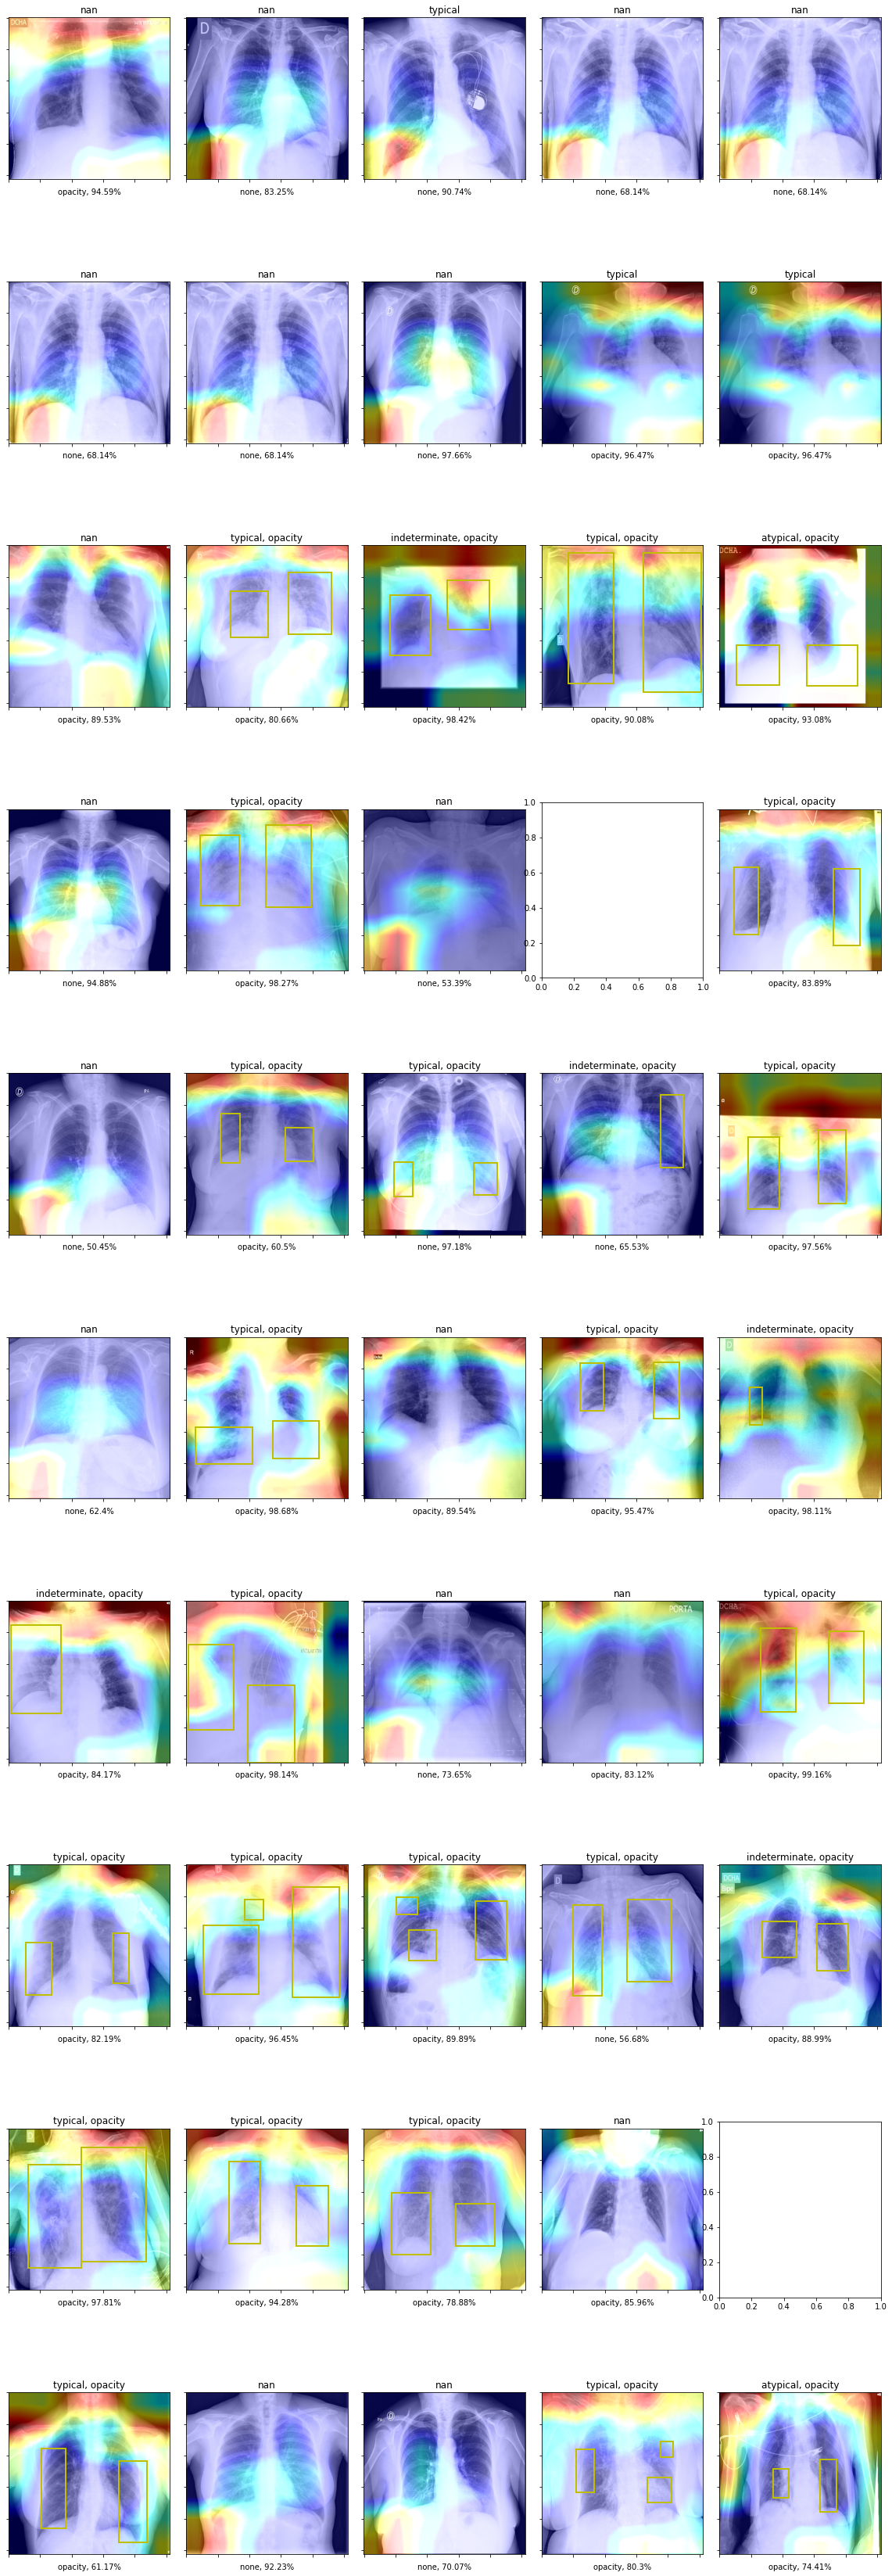

In [146]:
plot_results(model, valid_generator,label=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

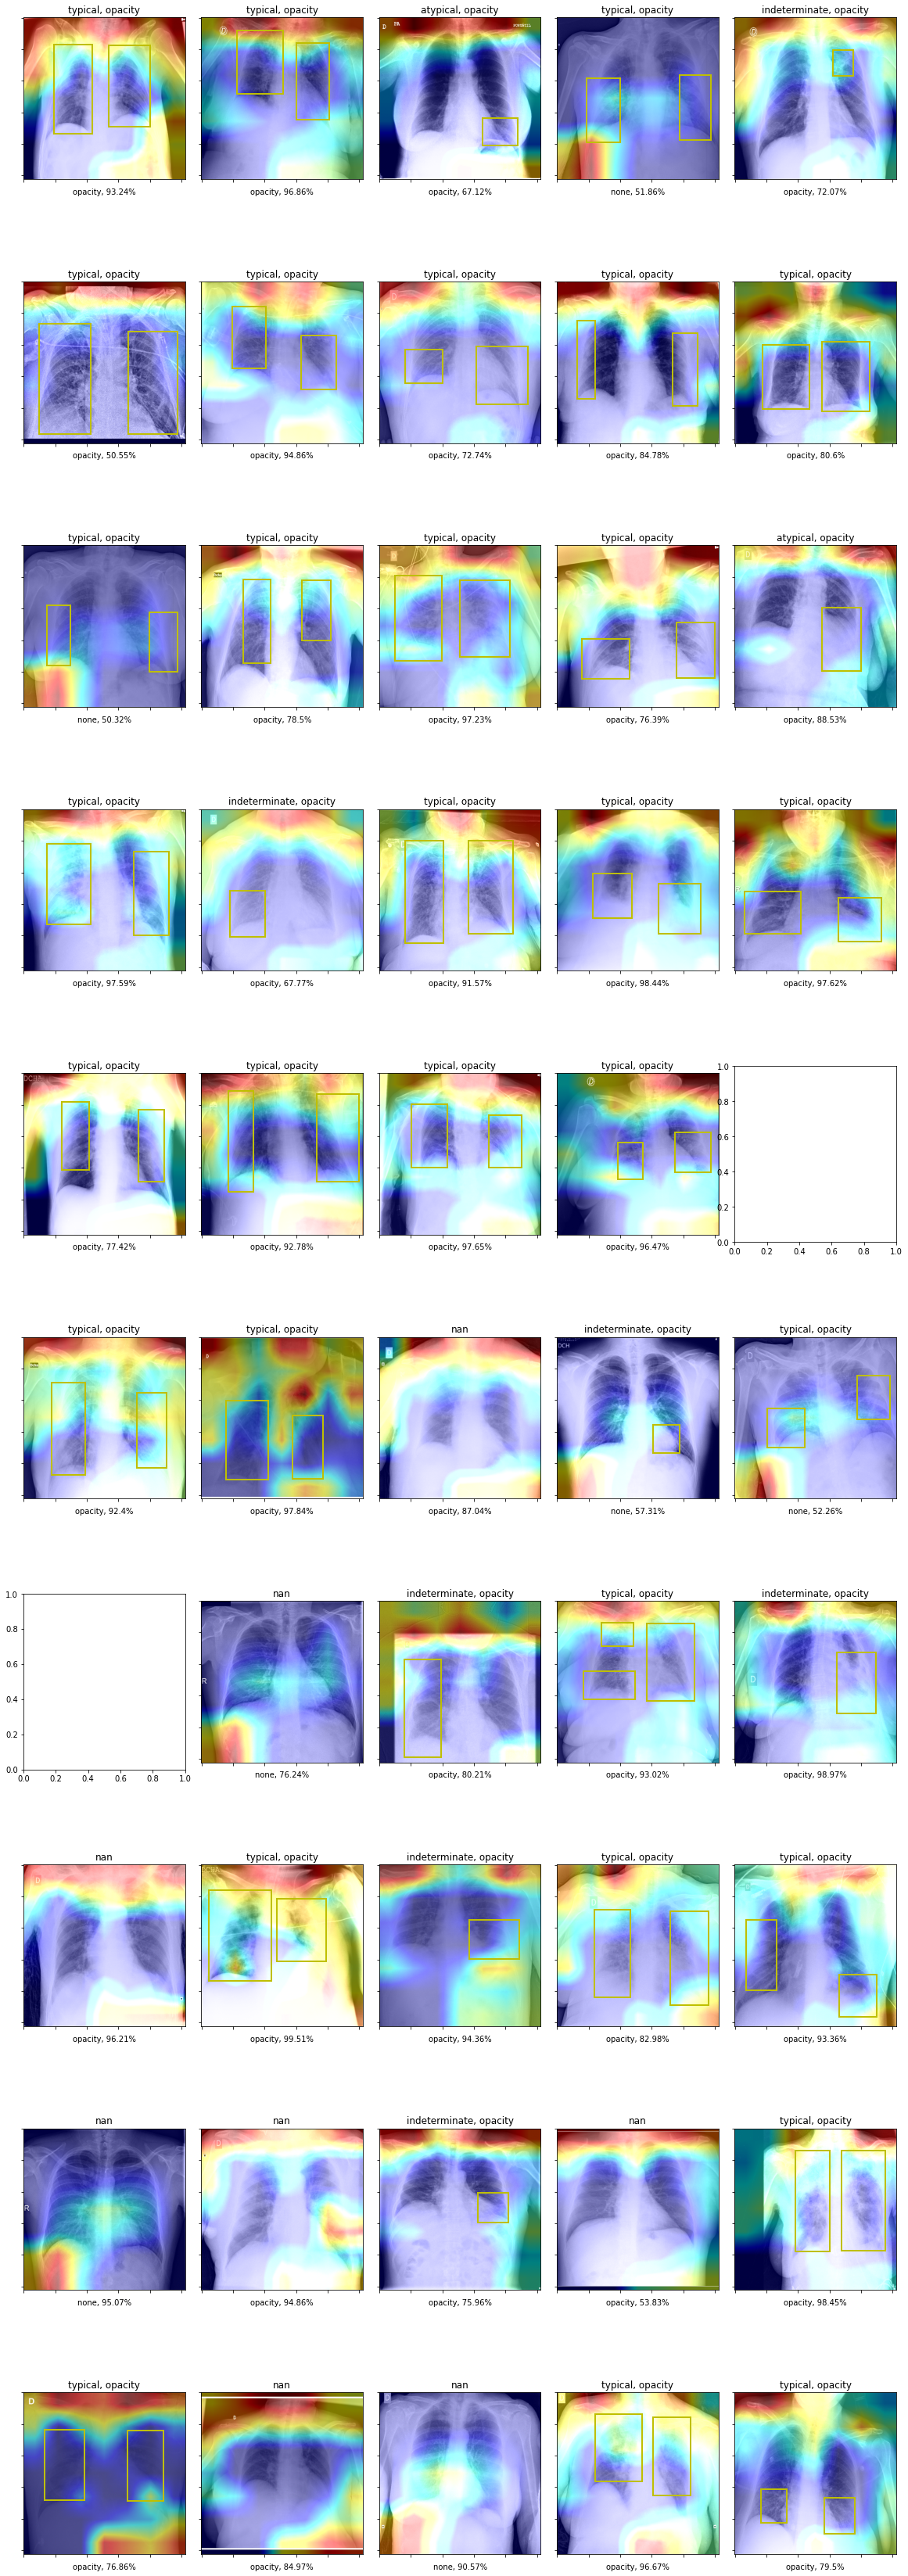

In [147]:
plot_results(model, valid_generator,label=1)

In [150]:
df_train[100:200]

id  ...  split
100  036fe057963a.png  ...  train
101  039159f7b61b.png  ...  train
102  039adaff232e.png  ...  train
103  039c86552c5a.png  ...  train
104  03a1614f51e7.png  ...  train
..                ...  ...    ...
195  06de06e37023.png  ...  train
196  06ee89a4efe9.png  ...  train
197  06f4f2f03a93.png  ...  train
198  06f6423be3f9.png  ...  train
199  30b18db28900.png  ...  train

[100 rows x 9 columns]

In [151]:
sample_img_path = os.path.join(train_dir, '06f4f2f03a93.png')
img = load_img(sample_img_path, target_size=(img_size, img_size))
img = img_to_array(img)
img = preprocess_image(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
pred = model.predict(img)
grad_cam_img = grad_cam(img, model, layer_name)
heatmap_img, result_img = blend(sample_img_path, grad_cam_img, 0.5)
axs[i].imshow(result_img[:,:,::-1]/255)

array([[0.2073359, 0.7926641]], dtype=float32)